In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import transforms, utils, datasets
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
import PIL
from PIL import Image
import PIL.Image as pilimg
from utils.labelgen_bear import CustomDataset_train, CustomDataset_valid
from models.call_model import Net


import os 
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
# make directory for save traing weight
PATH = './result/ckpt_folder_bear_1027/'
data_dir = './dataset/train/'
if not os.path.isdir(PATH):
    os.mkdir(PATH)

# define the hyper parameters for training
nb_batch = 32
nb_epochs = 75
lr = 1e-4
class_num_1 = 14
class_num_2 = 21
validation_split = 0.2
random_seed= 42
shuffle_dataset = True # shuffle dataset from training data for splitted dataset : entire_train = train + valid

In [3]:
#call training label
#Data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_validation = transforms.Compose([   
        transforms.ToTensor()])

dataset_train = CustomDataset_train(data_dir, class_num_1, class_num_2, validation_split, transform_train)
dataset_valid = CustomDataset_train(data_dir, class_num_1, class_num_2, validation_split, transform_validation)

#call training data
train_loader = DataLoader(dataset_train, batch_size=nb_batch)
valid_loader = DataLoader(dataset_valid, batch_size=nb_batch)

In [4]:
#setup training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40, 50, 60, 70], gamma= 0.5)



#loss function
def cross_entropy(pred, target, size_average=True):
 
    logsoftmax = nn.LogSoftmax()
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(pred), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(pred), dim=1))
    
criterion = cross_entropy

In [9]:
#start training
print("start training~!! =========================")

train_loss_check = []
loss_set = []
for epoch in range(nb_epochs):
    scheduler.step() # apply the learning rate scheduler
    
    model.train()
    for batch_idx, samples in enumerate(train_loader):
        x_train, x_ori, y_train1, y_train2 = samples
        bear
        #x_train = samples
        data, tar_1, tar_2 = x_train.to(device), y_train1.to(device), y_train2.to(device)
        optimizer.zero_grad()
        output_1, output_2 = model(data)
        
        # loss 
        loss1 = criterion(target=tar_1, pred=output_1)
        loss2 = criterion(target=tar_2, pred=output_2)
        
        loss_val = loss1 + loss2
        loss_val.backward()
        optimizer.step()
        
        train_loss_check.append(loss_val.item())
        if( batch_idx % 10 == 0 ):
            print("\t iteration num : {} // train loss value : {:.6f}".format(batch_idx, loss_val.item()))
        
    print("Epoch num : {} // train loss value : {:.6f}".format(epoch+1, loss_val.item()))
    PATH_ckpt = PATH + "epoch_" + str(epoch).zfill(3) + '_ckpt.pth'
    torch.save(model.state_dict(), PATH_ckpt)
    
    model.eval()
    with torch.no_grad(): # very very very very important!!!
        test_loss = []
        correct_1 = 0
        correct_2 = 0
        for batch_idx, samples in enumerate(valid_loader):
            x_test, y_test1, y_test2 = samples
            data, tar_1, tar_2 = x_test.to(device), y_test1.to(device), y_test2.to(device)
            output_1, output_2 = model(data)
            
            pred_1 = output_1.argmax(dim=1, keepdim=True)
            pred_2 = output_2.argmax(dim=1, keepdim=True)
            
            target_1 = tar_1.argmax(dim=1, keepdim=True)
            target_2 = tar_2.argmax(dim=1, keepdim=True)
            
            correct_1 += pred_1.eq( target_1.view_as(pred_1)  ).sum().item()
            correct_2 += pred_2.eq( target_2.view_as(pred_2)  ).sum().item()
            
            # loss value check
            loss1 = criterion(target=tar_1, pred=output_1)
            loss2 = criterion(target=tar_2, pred=output_2)

            loss_val = loss1 + loss2
            test_loss.append(loss_val.item())
            
        corr_1_val = (100. * correct_1) / len(valid_sampler)
        corr_2_val = (100. * correct_2) / len(valid_sampler)

        print("validation loss : {:.6f}".format( np.mean(test_loss) ))
        print("validation accuracy : case - 1 : {:.6f} // case-2 : {:.6f}".format(corr_1_val, corr_2_val) )
        
    loss_set.append([ np.mean(train_loss_check), np.mean(test_loss)])

start training~!! =========================


NameError: name 'bear' is not defined

In [10]:
img_aug = x_train[0].cpu().numpy()
img_input = x_ori[0].cpu().numpy()

In [7]:
import matplotlib.pyplot as plt

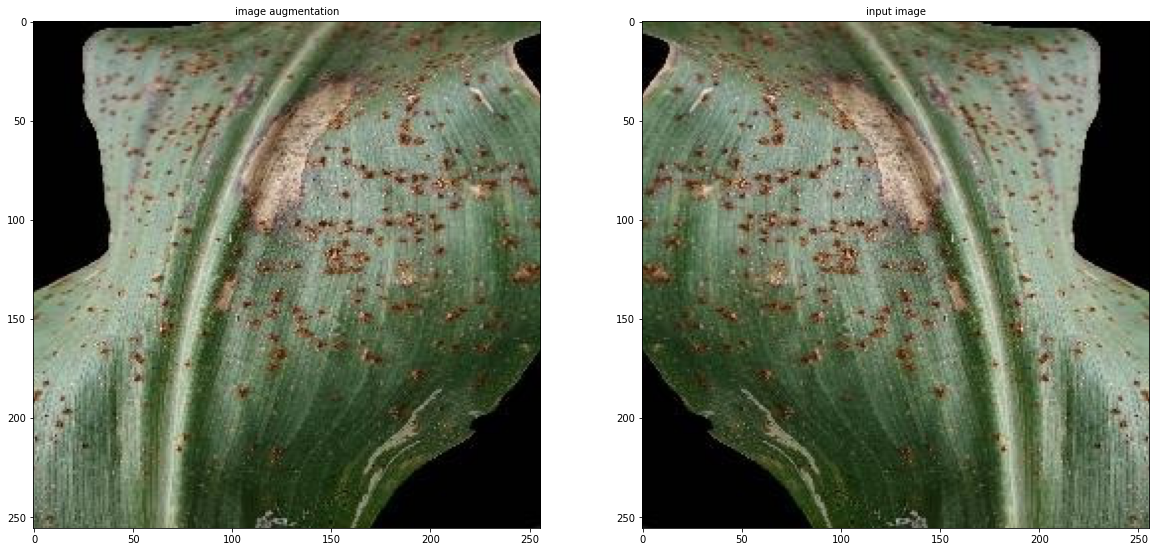

In [11]:
fig = plt.figure(figsize=(20,10))

img_trans = np.transpose(img_aug, (1, 2, 0))
plt.subplot(1,2,1)
plt.imshow( img_input )
plt.title('image augmentation', fontsize=10)

plt.subplot(1,2,2)
plt.imshow(img_trans)
plt.title('input image', fontsize=10)

plt.show()

In [ ]:
print(img_input.shape)
print(img_trans.shape)